In [1]:
# Challenge: https://www.kaggle.com/c/yelp-restaurant-photo-classification
import os
import numpy as np
import pandas as pd
import IPython
from IPython.display import SVG
import matplotlib.pyplot as plt
from scipy import misc
import pickle
import pydot
from collections import OrderedDict

# Keras (https://github.com/fchollet/keras/)
from keras.models import Sequential, Graph
from keras.layers.core import Flatten, Dense, Dropout, Activation
from keras.layers.convolutional import Convolution1D, Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.utils.visualize_util import plot, to_graph
from keras.utils import np_utils, generic_utils
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
from keras import callbacks


%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 20.0) # set default size of plots

Using Theano backend.


## Yelp data provider class

In [2]:
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

"""
-- Members --
train_photos_to_bizid_tbl: table photo - biz id
train_bizid_to_attrib_tbl: table biz id - attributes

train_biz_to_ps: dictionary biz id to photos
train_p_to_biz: dictionary photo to biz id
train_biz_to_attribs: dictionary biz id to attributes
"""
class YelpDataProvider(object):
    
    restaurant_attributes = {0: "good_for_lunch", 1: "good_for_dinner", 
                                2: "takes_reservations", 3: "outdoor_seating", 
                                4: "restaurant_is_expensive", 5: "has_alcohol", 
                                6: "has_table_service", 7: "ambience_is_classy", 
                                8: "good_for_kids"}
    
    # get business attributes
    def get_business_attribs(self, biz_id):
        
        return self.train_bizid_to_attrib_tbl[ \
                        self.train_bizid_to_attrib_tbl['business_id'] == biz_id]['labels'].tolist()[0].split(" ")
   
    def __init__(self, save_processed_data_at="../pdata"):
        
        self.save_processed = save_processed_data_at != None
        self.processed_data_dir = save_processed_data_at
        
    def load_training_data(self, train_data_dir="../input"):
        
        self.train_data_dir = train_data_dir
        self.train_photos_dir = os.path.join(train_data_dir,'train_photos')
        train_processed_data_dir = os.path.join(self.processed_data_dir,'train')
        
        if self.save_processed and os.path.isdir(train_processed_data_dir):
            
            self.train_photos_to_bizid_tbl = pd.read_csv(
                        os.path.join(train_processed_data_dir, 'train_photo_to_biz_ids.csv'))
            self.train_bizid_to_attrib_tbl = pd.read_csv(
                        os.path.join(train_processed_data_dir, 'train.csv'))
            
            self.train_biz_to_ps = pickle.load( open( 
                        os.path.join(train_processed_data_dir, "train_biz_to_ps.pkl"), "rb"))
            self.train_p_to_biz = pickle.load( open(
                        os.path.join(train_processed_data_dir, "train_p_to_biz.pkl"), "rb"))
            self.train_biz_to_attribs = pickle.load( open( 
                        os.path.join(train_processed_data_dir, "train_biz_to_attribs.pkl"), "rb"))
            
        else:
            
            self.train_photos_to_bizid_tbl = pd.read_csv(os.path.join(train_data_dir,'train_photo_to_biz_ids.csv'))
            self.train_bizid_to_attrib_tbl = pd.read_csv(os.path.join(train_data_dir,'train.csv'))
            
            # remove nas and duplicates
            self.train_bizid_to_attrib_tbl = self.train_bizid_to_attrib_tbl.dropna()
            self.train_bizid_to_attrib_tbl = self.train_bizid_to_attrib_tbl.drop_duplicates()
            
            # remove entries with no matching entry in attributes table
            self.train_photos_to_bizid_tbl['has_attribs'] = \
                            self.train_photos_to_bizid_tbl['business_id'].apply(
                                lambda x: True if x in self.train_bizid_to_attrib_tbl.business_id.values else False)
            self.train_photos_to_bizid_tbl = self.train_photos_to_bizid_tbl[ \
                                                    self.train_photos_to_bizid_tbl['has_attribs'] == True]
            self.train_photos_to_bizid_tbl = self.train_photos_to_bizid_tbl.drop('has_attribs', axis=1)
            for attrib_key,attrib in self.restaurant_attributes.items():
                self.train_bizid_to_attrib_tbl[attrib] = \
                            self.train_bizid_to_attrib_tbl['labels'].str.contains(str(attrib_key))
            
            # Dictionary: BIZ ID (one) -> Photos (many)
            self.train_biz_to_ps = {
                    k: g["photo_id"].tolist() for k,g in self.train_photos_to_bizid_tbl.groupby("business_id")}
            # Dictionary:  Photo (one) -> BIZ ID (one)
            self.train_p_to_biz = {
                    k: g["business_id"].values[0] for k,g in self.train_photos_to_bizid_tbl.groupby("photo_id")}
        
            self.train_biz_to_attribs = {
                    biz_id: self.get_business_attribs(biz_id) \
                        for biz_id in self.train_bizid_to_attrib_tbl['business_id']}
                
            if self.save_processed:
                
                # create dir to store processed data
                mkdir_p(os.path.join(train_processed_data_dir))

                # save processed tables to disk
                self.train_photos_to_bizid_tbl.to_csv( 
                        os.path.join(train_processed_data_dir, 'train_photo_to_biz_ids.csv'), index=False)
                self.train_bizid_to_attrib_tbl.to_csv(
                        os.path.join(train_processed_data_dir, 'train.csv'), index=False)

                # save dicts to disk
                pickle.dump(self.train_biz_to_ps, open( 
                            os.path.join(train_processed_data_dir, "train_biz_to_ps.pkl"), "wb"))
                pickle.dump(self.train_p_to_biz, open( 
                            os.path.join(train_processed_data_dir,"train_p_to_biz.pkl"), "wb"))
                pickle.dump(self.train_biz_to_attribs, open( 
                            os.path.join(train_processed_data_dir,"train_biz_to_attribs.pkl"), "wb"))
        
        self.total_num_train = len(self.train_p_to_biz)
        self.total_num_biz = len(self.train_biz_to_ps)
        self.reset_training_state()

    def load_test_data(self, test_data_dir="../input"):
        
        self.test_data_dir = test_data_dir
        self.test_photos_dir = os.path.join(test_data_dir,'test_photos')
        test_processed_data_dir = os.path.join(self.processed_data_dir, "test")
    
        if self.save_processed and os.path.isdir(test_processed_data_dir):
            
            self.test_photos_to_bizid_tbl = pd.read_csv(os.path.join(test_processed_data_dir,'test_photo_to_biz.csv'))
            self.test_p_to_biz = pickle.load( open(
                    os.path.join(test_processed_data_dir, "test_p_to_biz.pkl"), "rb"))
            self.test_biz_to_ps = pickle.load( open(
                    os.path.join(test_processed_data_dir, "test_biz_to_ps.pkl"), "rb"))
        else:
            
            self.test_photos_to_bizid_tbl = pd.read_csv(os.path.join(test_data_dir,'test_photo_to_biz.csv'))
            # Dictionary: BIZ ID (one) -> Photos (many)
            self.test_biz_to_ps = {
                    k: g["photo_id"].tolist() for k,g in self.test_photos_to_bizid_tbl.groupby("business_id")}
            # Dictionary:  Photo (one) -> BIZ ID (one)
            self.test_p_to_biz = {
                    k: g["business_id"].values[0] for k,g in self.test_photos_to_bizid_tbl.groupby("photo_id")}

            if self.save_processed:
                
                # create dir to store processed data
                mkdir_p(os.path.join(test_processed_data_dir))

                # save processed tables to disk
                self.test_photos_to_bizid_tbl.to_csv( 
                        os.path.join(test_processed_data_dir, 'test_photo_to_biz.csv'), index=False)
                
                # save dicts to disk
                pickle.dump(self.test_biz_to_ps, open( 
                            os.path.join(test_processed_data_dir, "test_biz_to_ps.pkl"), "wb"))
                pickle.dump(self.test_p_to_biz, open( 
                            os.path.join(test_processed_data_dir,"test_p_to_biz.pkl"), "wb"))
                
        self.total_num_test = len(self.test_biz_to_ps)
        self.reset_test_state()

    def reset_test_state(self):
        self.num_test_sampled = 0
        self.test_indices = np.arange(0, self.total_num_test)
        
    def reset_training_state(self):
        self.num_train_sampled = 0
        self.num_train_epoch = 0
        self.train_indices = np.arange(0, self.total_num_train)
        
    # read image from disk
    def read_image(self, image_file_path):
        return misc.imread(image_file_path)
    
    # read image by id from training photos dir
    def read_train_image(self, img_id):
        return misc.imread(os.path.join(self.train_photos_dir, str(img_id)+".jpg"))
    
    # read image by id from test photos dir
    def read_test_image(self, img_id):
        return misc.imread(os.path.join(self.test_photos_dir, str(img_id)+".jpg"))

    # output labels
    def get_business_attribs_one_hot_enc(self, biz_id, num_classes=len(restaurant_attributes)):
        return np.array([ (0,1)[str(i) in self.get_business_attribs(biz_id)] for i in range(num_classes)])
    
    # read training image by index (image to biz table)
    def read_train_image_at_idx(self, img_idx):
        return self.read_train_image(list(self.train_p_to_biz.keys())[img_idx])
    
    # read test image by index (image to biz table)
    def read_test_image_at_idx(self, img_idx):
        return self.read_test_image(list(self.test_p_to_biz.keys())[img_idx])
    
    # preprocess image
    def __prepare_image_vggnet(self, img, resize_dim=(224, 224, 3), 
                                   sub_vgg_mean=False, depth_first=True, dtype=np.float32):
        
        img = misc.imresize(img, resize_dim, interp="nearest").astype(dtype)
        
        if sub_vgg_mean:
            img[:,:,0] -= 103.939
            img[:,:,1] -= 116.779
            img[:,:,2] -= 123.68

        if depth_first:
            img = img.transpose((2,0,1))
            
        return img
    
    def sample_test_biz_images(self, resize_input_to = (224, 224, 3), 
                                      preprocess = True, depth_first = True, dtype=np.float32):

        for biz_id in list(self.test_biz_to_ps.keys()):
            
            biz_imgs = np.array([self.__prepare_image_vggnet(self.read_test_image(img_id),
                                            resize_dim = resize_input_to,
                                            sub_vgg_mean = (preprocess==True),
                                            depth_first = depth_first,
                                            dtype=dtype) \
                                    for img_id in self.test_biz_to_ps[biz_id]])
            yield biz_id, biz_imgs
            
    def sample_test_minibatch(self, size = 16, resize_input_to = (224, 224, 3), 
                                      preprocess = True, depth_first = True, dtype=np.float32):
 
        width, height, channels = resize_input_to
        num_test = size
        
        # Get whole dataset
        if num_test == -1:
            num_test = self.total_num_test
        
        print('sample {} datapoints without replacement, range {}-{}'.format(
                                size, self.num_test_sampled, self.num_test_sampled+size))
        test_indices = self.test_indices[self.num_test_sampled: self.num_test_sampled+size] 
            
        self.num_test_sampled += size
        
        X_test = np.array([self.__prepare_image_vggnet(self.read_test_image_at_idx(rand_id), 
                                            resize_dim = resize_input_to,
                                            sub_vgg_mean = (preprocess==True),
                                            depth_first = depth_first,
                                            dtype=dtype) \
                            for rand_id in test_indices[:num_test]])
        return X_test
    
    # sample images from training dataset
    def sample_training_minibatch(self, size = 16, resize_input_to = (224, 224, 3), 
                                    num_classes = 9, percent_validation = 0, 
                                    preprocess = True, depth_first = True, shuffle_before_each_epoch = True,
                                    replace = False, dtype=np.float32):
        
        if (self.num_train_sampled == 0) or (self.total_num_train % self.num_train_sampled) == 0:
        # new epoch begins
            
            self.num_train_sampled = 0
            
            if self.num_train_sampled != 0:
                self.num_train_epoch += 1
            
            if shuffle_before_each_epoch == True:
                # shuffle the dataset at the beginning of each epoch
                np.random.shuffle(self.train_indices)
 
        width, height, channels = resize_input_to
        
        # Get whole dataset
        if size == -1:
            size = self.total_num_train
        
        # Train <-> Valid split
        num_train = int(size * (1.0 - percent_validation))
        num_valid = size - num_train
        
        if replace == True:
            
            print('sample {} datapoints with replacement'.format(size))
            train_indices = np.random.randint(0, self.total_num_train, size)
            
        else:
            print('sample {} datapoints without replacement, range {}-{}'.format(
                                    size, self.num_train_sampled, self.num_train_sampled+size))
            train_indices = self.train_indices[self.num_train_sampled: self.num_train_sampled+size] 
            
        self.num_train_sampled += size
        
        X_train = np.array([self.__prepare_image_vggnet(self.read_train_image_at_idx(rand_id), 
                                            resize_dim = resize_input_to,
                                            sub_vgg_mean = (preprocess==True),
                                            depth_first = depth_first,
                                            dtype=dtype) \
                            for rand_id in train_indices[:num_train]])
        y_train = np.array([self.get_business_attribs_one_hot_enc(list(self.train_p_to_biz.values())[rand_id], 
                                                                num_classes) for rand_id in train_indices[:num_train]])
        if not num_valid:
            return X_train, y_train
        
        X_valid = np.array([self.__prepare_image_vggnet(self.read_train_image_at_idx(rand_id), 
                                            resize_dim = resize_input_to,
                                            sub_vgg_mean = (preprocess==True),
                                            depth_first = depth_first,
                                            dtype=dtype) \
                                        for rand_id in train_indices[-num_valid:]])
        y_valid = np.array([self.get_business_attribs_one_hot_enc(list(self.train_p_to_biz.values())[rand_id], 
                                                                num_classes) for rand_id in train_indices[-num_valid:]])
        
        return X_train, y_train, X_valid, y_valid
    
    def sample_training_images_by_class(self, class_name, max_biz = 10, max_biz_imgs = 10,
                                                resize_input_to = (224, 224, 3), 
                                                num_classes = 9, percent_validation = 0, 
                                                preprocess = True, depth_first = True, dtype=np.float32):
        
        # iterate over business with attrib class_name
        filtered_tbl = self.train_bizid_to_attrib_tbl[self.train_bizid_to_attrib_tbl[class_name] == True]
   
        for biz_idx, biz_id in enumerate(filtered_tbl["business_id"].values[:max_biz]):
            # iterate over all photos of that particular business 
            for img_id in self.train_biz_to_ps[biz_id][:max_biz_imgs]:
                yield self.__prepare_image_vggnet(self.read_train_image(img_id),
                                            resize_dim = resize_input_to,
                                            sub_vgg_mean = (preprocess==True),
                                            depth_first = depth_first,
                                            dtype=dtype)

## Read input data

In [7]:
yelp_data_provider = YelpDataProvider()
yelp_data_provider.load_training_data()
yelp_data_provider.load_test_data()

images per biz min = 2, max = 2974, mean = 117.50751503, std = 205.164285908


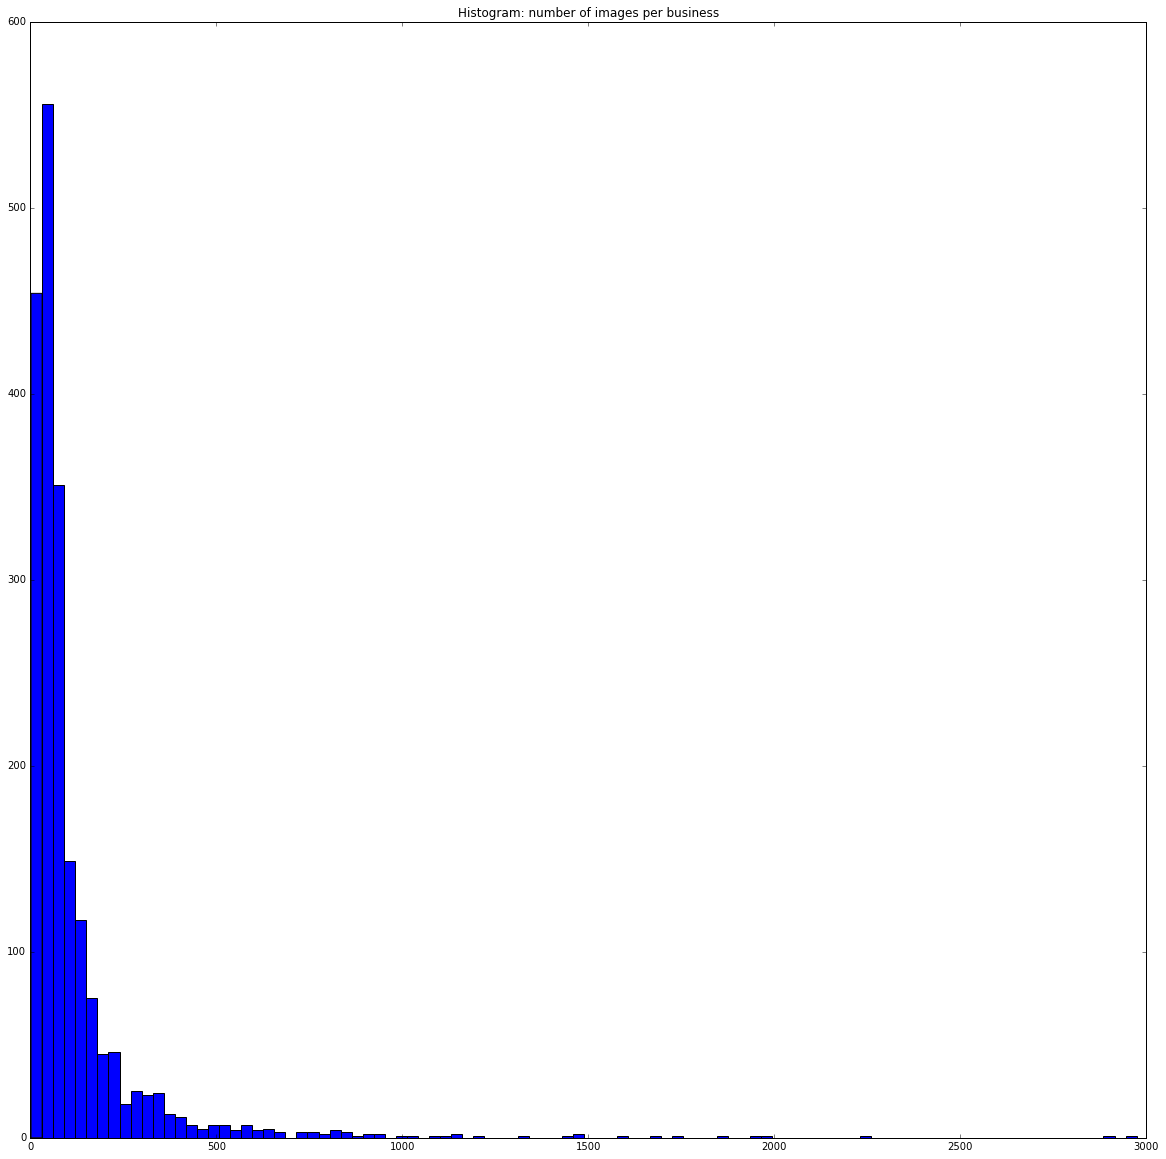

In [8]:
n_biz_images = np.array([ len(yelp_data_provider.train_biz_to_ps[biz_id]) \
                                     for biz_id in yelp_data_provider.train_biz_to_ps.keys() ])
print('images per biz min = {}, max = {}, mean = {}, std = {}'.format(
        n_biz_images.min(), n_biz_images.max(), n_biz_images.mean(), n_biz_images.std()))
plt.hist(n_biz_images, log = False, bins = 100)
plt.title("Histogram: number of images per business")

In [10]:
def threshold_effect(t):
    
    num_biz = np.sum(n_biz_images < t)
    percent_biz = 100*np.sum(n_biz_images < t)/float(len(n_biz_images))
    
    num_imgs = np.sum(n_biz_images < t)
    percent_imgs = 100*np.sum(n_biz_images[n_biz_images < t])/float(np.sum(n_biz_images))
    # print('t = {}, compromises biz {}%, training images {}%'.format(t, percent_biz, percent_imgs))
    return percent_biz, percent_imgs

In [11]:
threshold_effect(15)

(5.3607214428857715, 0.48562109616491506)

**Need a model which takes variable number of images from a business as input and maps it to business attributes. This is tricky. One way to do so is to train the model with least amount of images available per business. But, the minimum is two which isn't sufficient for learning all the attributes. So we'd have to sacrifice some businesses. As it can be seen, there are 107 businesses which has < 15 images, contributing to total of 1139 images of the dataset, which seems like a pretty good threshold because it's only 0.48% of the total training images. Let's check the effect of threshold values in range 0-100**

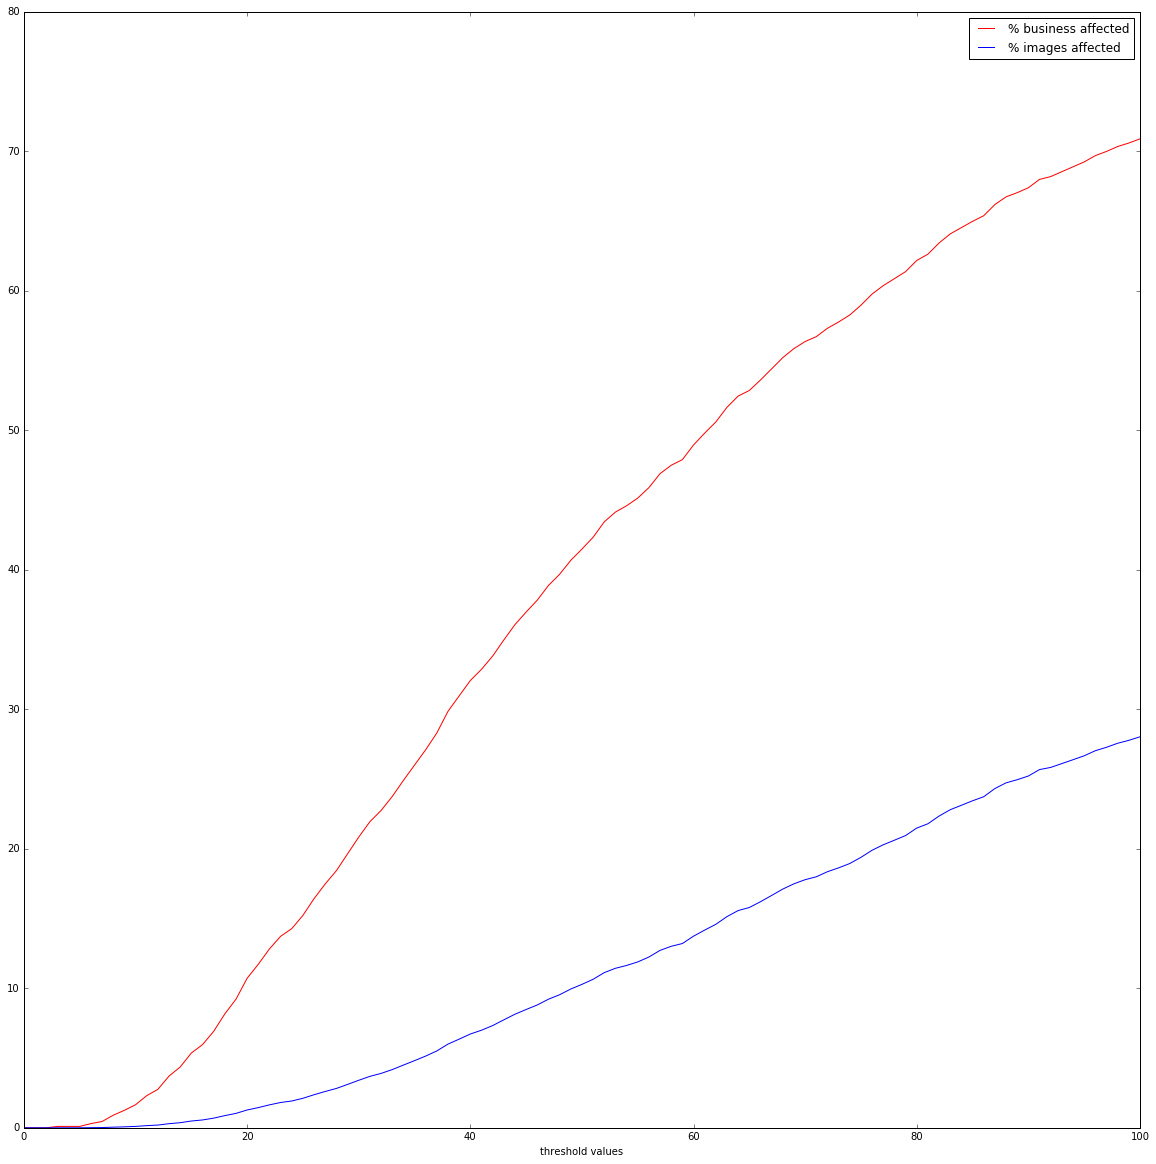

In [12]:
t_result_biz = []
t_result_imgs = []
t_range = range(101)
for t in t_range:
    b, i = threshold_effect(t)
    t_result_biz.append(b)
    t_result_imgs.append(i)
    
plt.xlabel("threshold values")
plt.plot(t_range, t_result_biz, color="r", label="% business affected")
plt.plot(t_range, t_result_imgs, color="b", label="% images affected")
plt.legend()

Looking at this graph, threshold 20 seems like a good minimum number of images that we can expect from a business without impacting overall performance. 

In [13]:
print threshold_effect(20)

(10.721442885771543, 1.2773668166023577)


sample 16 datapoints without replacement, range 0-16


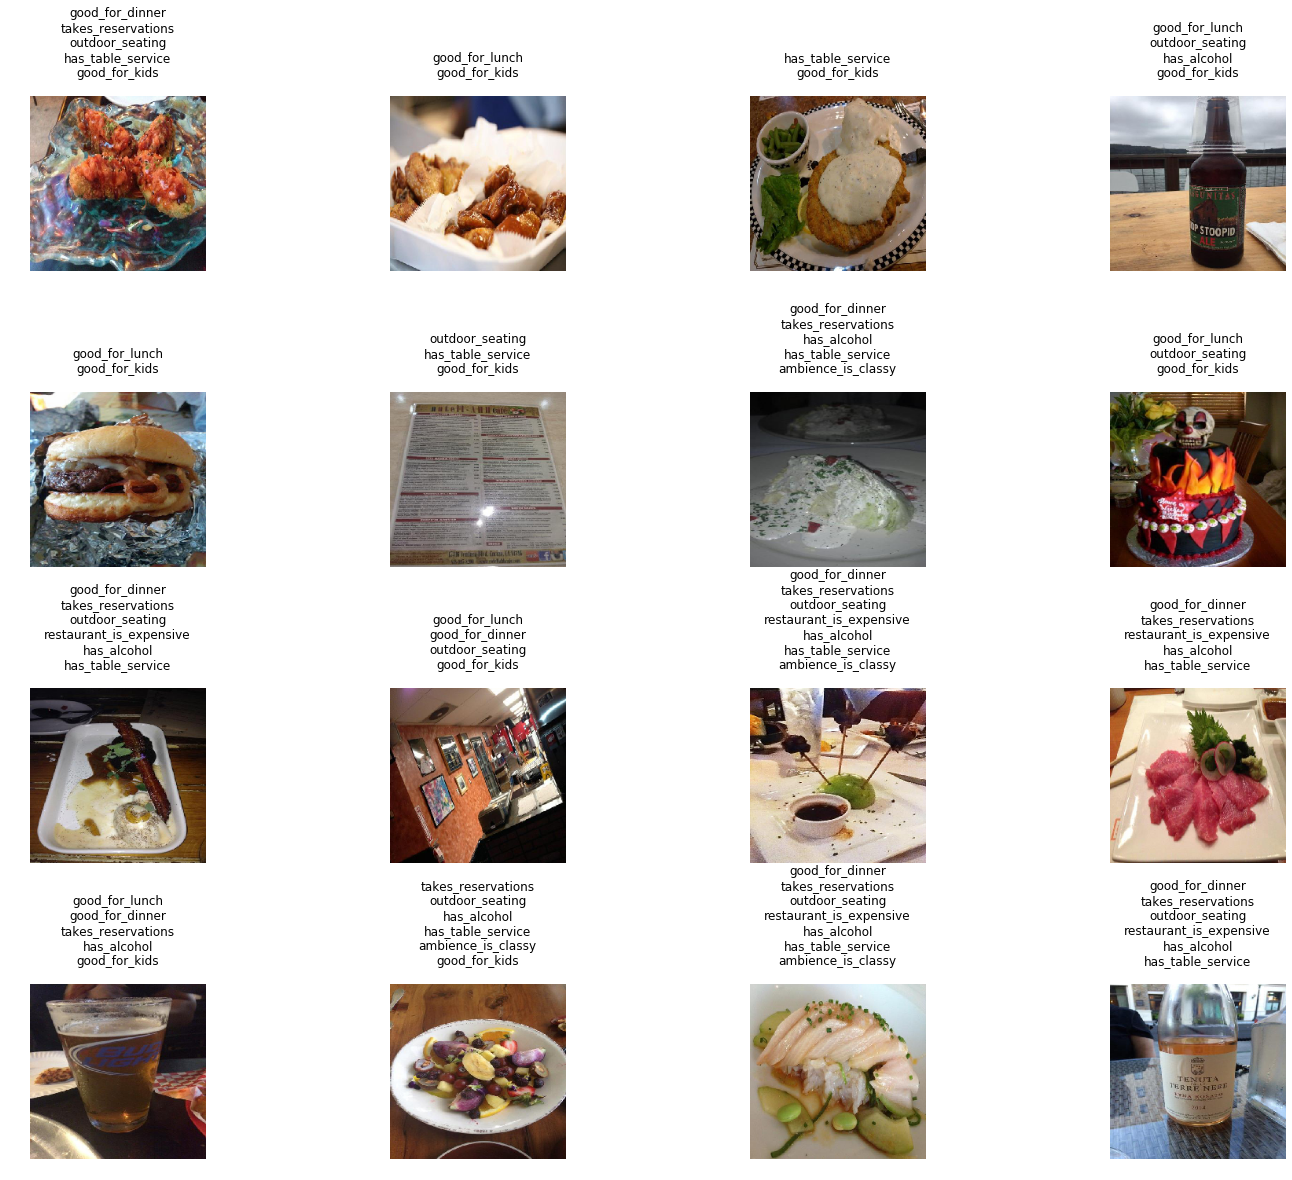

In [14]:
# sample few images
num_samples = 16
X_train, y_train = yelp_data_provider.sample_training_minibatch(size=num_samples, preprocess = False, 
                                                                    depth_first = False, dtype=np.uint8)
for i in range(num_samples):
    plt.subplot(np.sqrt(num_samples)+1, np.sqrt(num_samples), i+1)
    
    plt.axis('off')
    title_str = "".join([ yelp_data_provider.restaurant_attributes[idx] + "\n" if val else "" \
                                     for idx,val in enumerate(y_train[i])])
    plt.title(title_str)
    plt.imshow(X_train[i])
plt.tight_layout(pad=0)

## Visualize class images

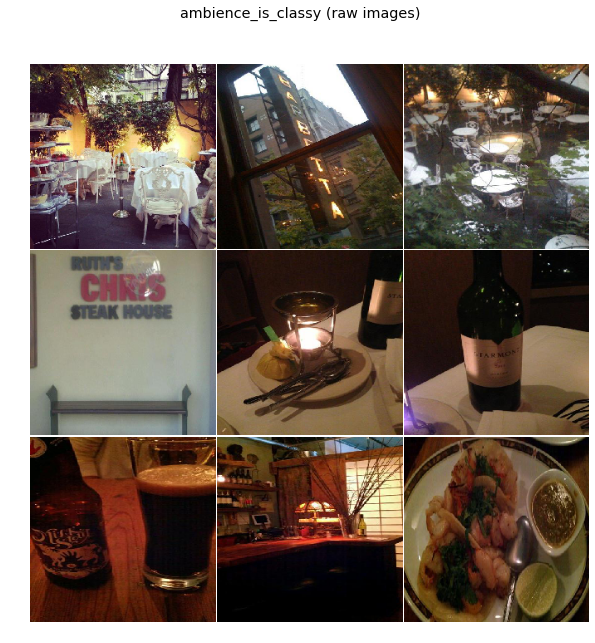

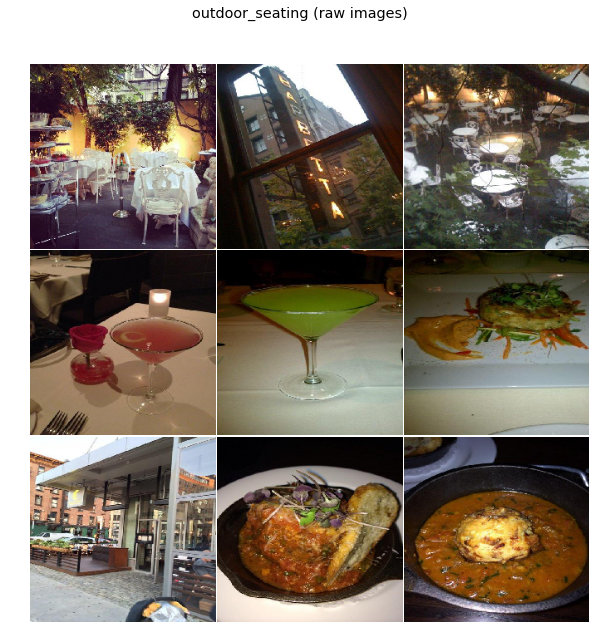

In [15]:
class_names =  ["ambience_is_classy", "outdoor_seating"]

for i, class_name in enumerate(class_names):
    fig = plt.figure(i, figsize=(10,10))
    st = fig.suptitle(class_name + " (raw images)", fontsize="x-large")
    max_biz, max_imgs_per_biz = 3, 3
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    for image_no, img in enumerate(
                yelp_data_provider.sample_training_images_by_class(class_name, max_biz, max_imgs_per_biz, 
                                                                        preprocess = False, depth_first = False, 
                                                                        dtype=np.uint8)):
        plt.subplot(max_biz, max_imgs_per_biz, image_no+1)
        plt.axis("off")
        plt.imshow(img)

## Tansfer Learning

In [19]:
# VGG16 (trained on ImageNet)
def VGG_16(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))

    if weights_path:
        model.load_weights(weights_path)

    return model

## Restaurant Classification Model

In [20]:
def yelp_restaurant_classifier(fc_dims = (1024, 512, 1), l2_reg = 0.1, weights_path=None): # sample model
    
    fc1_dim, fc2_dim, output_dim = fc_dims
    
    m = Graph()
    
    #64 repr
    m.add_input(name='input', input_shape=(3,224,224))
    m.add_node(ZeroPadding2D((1,1)), name="pad0", input="input")
    m.add_node(Convolution2D(64, 3, 3, activation='relu'), name="conv1", input="pad0")
    m.add_node(ZeroPadding2D((1,1)), name="pad1", input="conv1")
    m.add_node(Convolution2D(64, 3, 3, activation='relu'), name="conv2", input="pad1")
    m.add_node(MaxPooling2D((2,2), strides=(2,2)), name="maxp2", input="conv2")

    #128 repr
    m.add_node(ZeroPadding2D((1,1)), name="pad2", input="maxp2")
    m.add_node(Convolution2D(128, 3, 3, activation='relu'), name="conv3", input="pad2")
    m.add_node(ZeroPadding2D((1,1)), name="pad3", input="conv3")
    m.add_node(Convolution2D(128, 3, 3, activation='relu'), name="conv4", input="pad3")
    m.add_node(MaxPooling2D((2,2), strides=(2,2)), name="maxp4", input="conv4")

    #256 repr
    m.add_node(ZeroPadding2D((1,1)), name="pad4", input="maxp4")
    m.add_node(Convolution2D(256, 3, 3, activation='relu'), name="conv5", input="pad4")
    m.add_node(ZeroPadding2D((1,1)), name="pad5", input="conv5")
    m.add_node(Convolution2D(256, 3, 3, activation='relu'), name="conv6", input="pad5")
    m.add_node(ZeroPadding2D((1,1)), name="pad6", input="conv6")
    m.add_node(Convolution2D(256, 3, 3, activation='relu'), name="conv7", input="pad6")
    m.add_node(MaxPooling2D((2,2), strides=(2,2)), name="maxp7", input="conv7")

    #512 repr
    m.add_node(ZeroPadding2D((1,1)), name="pad7", input="maxp7")
    m.add_node(Convolution2D(512, 3, 3, activation='relu'), name="conv8", input="pad7")
    m.add_node(ZeroPadding2D((1,1)), name="pad8", input="conv8")
    m.add_node(Convolution2D(512, 3, 3, activation='relu'), name="conv9", input="pad8")
    m.add_node(ZeroPadding2D((1,1)), name="pad9", input="conv9")
    m.add_node(Convolution2D(512, 3, 3, activation='relu'), name="conv10", input="pad9")
    m.add_node(MaxPooling2D((4,4), strides=(2,2)), name="maxp10", input="conv10")
    
    #512 repr
    m.add_node(ZeroPadding2D((1,1)), name="pad10", input="maxp10")
    m.add_node(Convolution2D(512, 3, 3, activation='relu'), name="conv11", input="pad10")
    m.add_node(ZeroPadding2D((1,1)), name="pad11", input="conv11")
    m.add_node(Convolution2D(512, 3, 3, activation='relu'), name="conv12", input="pad11")
    m.add_node(ZeroPadding2D((1,1)), name="pad12", input="conv12")
    m.add_node(Convolution2D(512, 3, 3, activation='relu'), name="conv13", input="pad12")
    m.add_node(MaxPooling2D((4,4), strides=(2,2)), name="maxp13", input="conv13")
    
    m.add_node(Flatten(), name="fork", input="maxp13")
    
    m.add_node(Dense(fc1_dim, activation='relu', init='he_normal', W_regularizer = l2(l2_reg)), name="h1fc1", input="fork")
    m.add_node(Dropout(0.5), name="h1fc1_drop", input="h1fc1")
    m.add_node(Dense(fc2_dim, activation='relu', init='he_normal', W_regularizer = l2(l2_reg)), name="h1fc2", input="h1fc1_drop")
    m.add_node(Dropout(0.5), name="h1fc2_drop", input="h1fc2")
    m.add_node(Dense(output_dim, activation='sigmoid', init='he_normal', W_regularizer = l2(l2_reg)), name="h1out", input="h1fc2_drop")
    
    m.add_node(Dense(fc1_dim, activation='relu', init='he_normal', W_regularizer = l2(l2_reg)), name="h2fc1", input="fork")
    m.add_node(Dropout(0.5), name="h2fc1_drop", input="h2fc1")
    m.add_node(Dense(fc2_dim, activation='relu', init='he_normal', W_regularizer = l2(l2_reg)), name="h2fc2", input="h2fc1_drop")
    m.add_node(Dropout(0.5), name="h2fc2_drop", input="h2fc2")
    m.add_node(Dense(output_dim, activation='sigmoid', init='he_normal', W_regularizer = l2(l2_reg)), name="h2out", input="h2fc2_drop")
    
    m.add_node(Dense(fc1_dim, activation='relu', init='he_normal', W_regularizer = l2(l2_reg)), name="h3fc1", input="fork")
    m.add_node(Dropout(0.5), name="h3fc1_drop", input="h3fc1")
    m.add_node(Dense(fc2_dim, activation='relu', init='he_normal', W_regularizer = l2(l2_reg)), name="h3fc2", input="h3fc1_drop")
    m.add_node(Dropout(0.5), name="h3fc2_drop", input="h3fc2")
    m.add_node(Dense(output_dim, activation='sigmoid', init='he_normal', W_regularizer = l2(l2_reg)), name="h3out", input="h3fc2_drop")
    
    m.add_node(Dense(fc1_dim, activation='relu', init='he_normal', W_regularizer = l2(l2_reg)), name="h4fc1", input="fork")
    m.add_node(Dropout(0.5), name="h4fc1_drop", input="h4fc1")
    m.add_node(Dense(fc2_dim, activation='relu', init='he_normal', W_regularizer = l2(l2_reg)), name="h4fc2", input="h4fc1_drop")
    m.add_node(Dropout(0.5), name="h4fc2_drop", input="h4fc2")
    m.add_node(Dense(output_dim, activation='sigmoid', init='he_normal', W_regularizer = l2(l2_reg)), name="h4out", input="h4fc2_drop")
    
    m.add_node(Dense(fc1_dim, activation='relu', init='he_normal', W_regularizer = l2(l2_reg)), name="h5fc1", input="fork")
    m.add_node(Dropout(0.5), name="h5fc1_drop", input="h5fc1")
    m.add_node(Dense(fc2_dim, activation='relu', init='he_normal', W_regularizer = l2(l2_reg)), name="h5fc2", input="h5fc1_drop")
    m.add_node(Dropout(0.5), name="h5fc2_drop", input="h5fc2")
    m.add_node(Dense(output_dim, activation='sigmoid', init='he_normal', W_regularizer = l2(l2_reg)), name="h5out", input="h5fc2_drop")
    
    m.add_node(Dense(fc1_dim, activation='relu', init='he_normal', W_regularizer = l2(l2_reg)), name="h6fc1", input="fork")
    m.add_node(Dropout(0.5), name="h6fc1_drop", input="h6fc1")
    m.add_node(Dense(fc2_dim, activation='relu', init='he_normal', W_regularizer = l2(l2_reg)), name="h6fc2", input="h6fc1_drop")
    m.add_node(Dropout(0.5), name="h6fc2_drop", input="h6fc2")
    m.add_node(Dense(output_dim, activation='sigmoid', init='he_normal', W_regularizer = l2(l2_reg)), name="h6out", input="h6fc2_drop")
    
    m.add_node(Dense(fc1_dim, activation='relu', init='he_normal', W_regularizer = l2(l2_reg)), name="h7fc1", input="fork")
    m.add_node(Dropout(0.5), name="h7fc1_drop", input="h7fc1")
    m.add_node(Dense(fc2_dim, activation='relu', init='he_normal', W_regularizer = l2(l2_reg)), name="h7fc2", input="h7fc1_drop")
    m.add_node(Dropout(0.5), name="h7fc2_drop", input="h7fc2")
    m.add_node(Dense(output_dim, activation='sigmoid', init='he_normal', W_regularizer = l2(l2_reg)), name="h7out", input="h7fc2_drop")
    
    m.add_node(Dense(fc1_dim, activation='relu', init='he_normal', W_regularizer = l2(l2_reg)), name="h8fc1", input="fork")
    m.add_node(Dropout(0.5), name="h8fc1_drop", input="h8fc1")
    m.add_node(Dense(fc2_dim, activation='relu', init='he_normal', W_regularizer = l2(l2_reg)), name="h8fc2", input="h8fc1_drop")
    m.add_node(Dropout(0.5), name="h8fc2_drop", input="h8fc2")
    m.add_node(Dense(output_dim, activation='sigmoid', init='he_normal', W_regularizer = l2(l2_reg)), name="h8out", input="h8fc2_drop")
    
    m.add_node(Dense(fc1_dim, activation='relu', init='he_normal', W_regularizer = l2(l2_reg)), name="h9fc1", input="fork")
    m.add_node(Dropout(0.5), name="h9fc1_drop", input="h9fc1")
    m.add_node(Dense(fc2_dim, activation='relu', init='he_normal', W_regularizer = l2(l2_reg)), name="h9fc2", input="h9fc1_drop")
    m.add_node(Dropout(0.5), name="h9fc2_drop", input="h9fc2")
    m.add_node(Dense(output_dim, activation='sigmoid', init='he_normal', W_regularizer = l2(l2_reg)), name="h9out", input="h9fc2_drop")
    
    m.add_output(name='class_0', input='h1out')
    m.add_output(name='class_1', input='h2out')
    m.add_output(name='class_2', input='h3out')
    m.add_output(name='class_3', input='h4out')
    m.add_output(name='class_4', input='h5out')
    m.add_output(name='class_5', input='h6out')
    m.add_output(name='class_6', input='h7out')
    m.add_output(name='class_7', input='h8out')
    m.add_output(name='class_8', input='h9out')

    if weights_path and os.path.isfile(weights_path):
        print "loading pre-trained weights from: ", weights_path
        m.load_weights(weights_path)

    return m

# Transfer Learning utility functions
def transfer_learn_conv_layers(dst_model_graph, src_model_seq, transfer_end_at = "conv13"):
    
    conv_idx = 0
    for i in range(len(src_model_seq.layers)):
        
        # vgg16_model.layers[i].name supported in latest keras
        if "Convolution2D" in str(src_model_seq.layers[i]): 
            
            conv_idx += 1
            conv_layer_name = "conv" + str(conv_idx)
            if conv_layer_name in dst_model_graph.namespace:
                
                print('Transferring weights layer {}(src) -> {}(dst)'.format(i, conv_idx))
                dst_model_graph.nodes[conv_layer_name].W.set_value(src_model_seq.layers[i].get_weights()[0]);
                dst_model_graph.nodes[conv_layer_name].b.set_value(src_model_seq.layers[i].get_weights()[1]);
        
            if conv_layer_name == transfer_end_at:
                break
            
def freeze_layers_from_bottom(model_graph, freeze_end_at = "conv4"):

    # freeze bottom layers
    for node_name in model_graph.nodes.keys():
        model_graph.nodes[node_name].trainable = False
        if node_name == freeze_end_at:
            break

In [21]:
yelp_weights_path = "./yelp_restaurant_classifier_weights.h5"

if os.path.isfile(yelp_weights_path):
    
    # start from previous state
    print('Load previous model from disk')
    yelp_model = yelp_restaurant_classifier(fc_dims = (1024, 512, 1), l2_reg = 1.0, weights_path=yelp_weights_path)
    freeze_layers_from_bottom(yelp_model, "conv4")
    
else:
    
    # transfer learn from VGG16
    print('Creating new model...')
    yelp_model = yelp_restaurant_classifier(fc_dims = (1024, 512, 1), l2_reg = 1.0, weights_path=None)
    print('Loading teacher...')
    vgg16_model = VGG_16('vgg16_weights.h5')
    print('Transfer learning...')
    transfer_learn_conv_layers(yelp_model, vgg16_model, "conv10") # orig: conv13
    freeze_layers_from_bottom(yelp_model, "conv4")
    del vgg16_model
    print('Completed. Ready to learn more.')

Creating new model...
Loading teacher...
Transfer learning...
Transferring weights layer 1(src) -> 1(dst)
Transferring weights layer 3(src) -> 2(dst)
Transferring weights layer 6(src) -> 3(dst)
Transferring weights layer 8(src) -> 4(dst)
Transferring weights layer 11(src) -> 5(dst)
Transferring weights layer 13(src) -> 6(dst)
Transferring weights layer 15(src) -> 7(dst)
Transferring weights layer 18(src) -> 8(dst)
Transferring weights layer 20(src) -> 9(dst)
Transferring weights layer 22(src) -> 10(dst)
Completed. Ready to learn more.


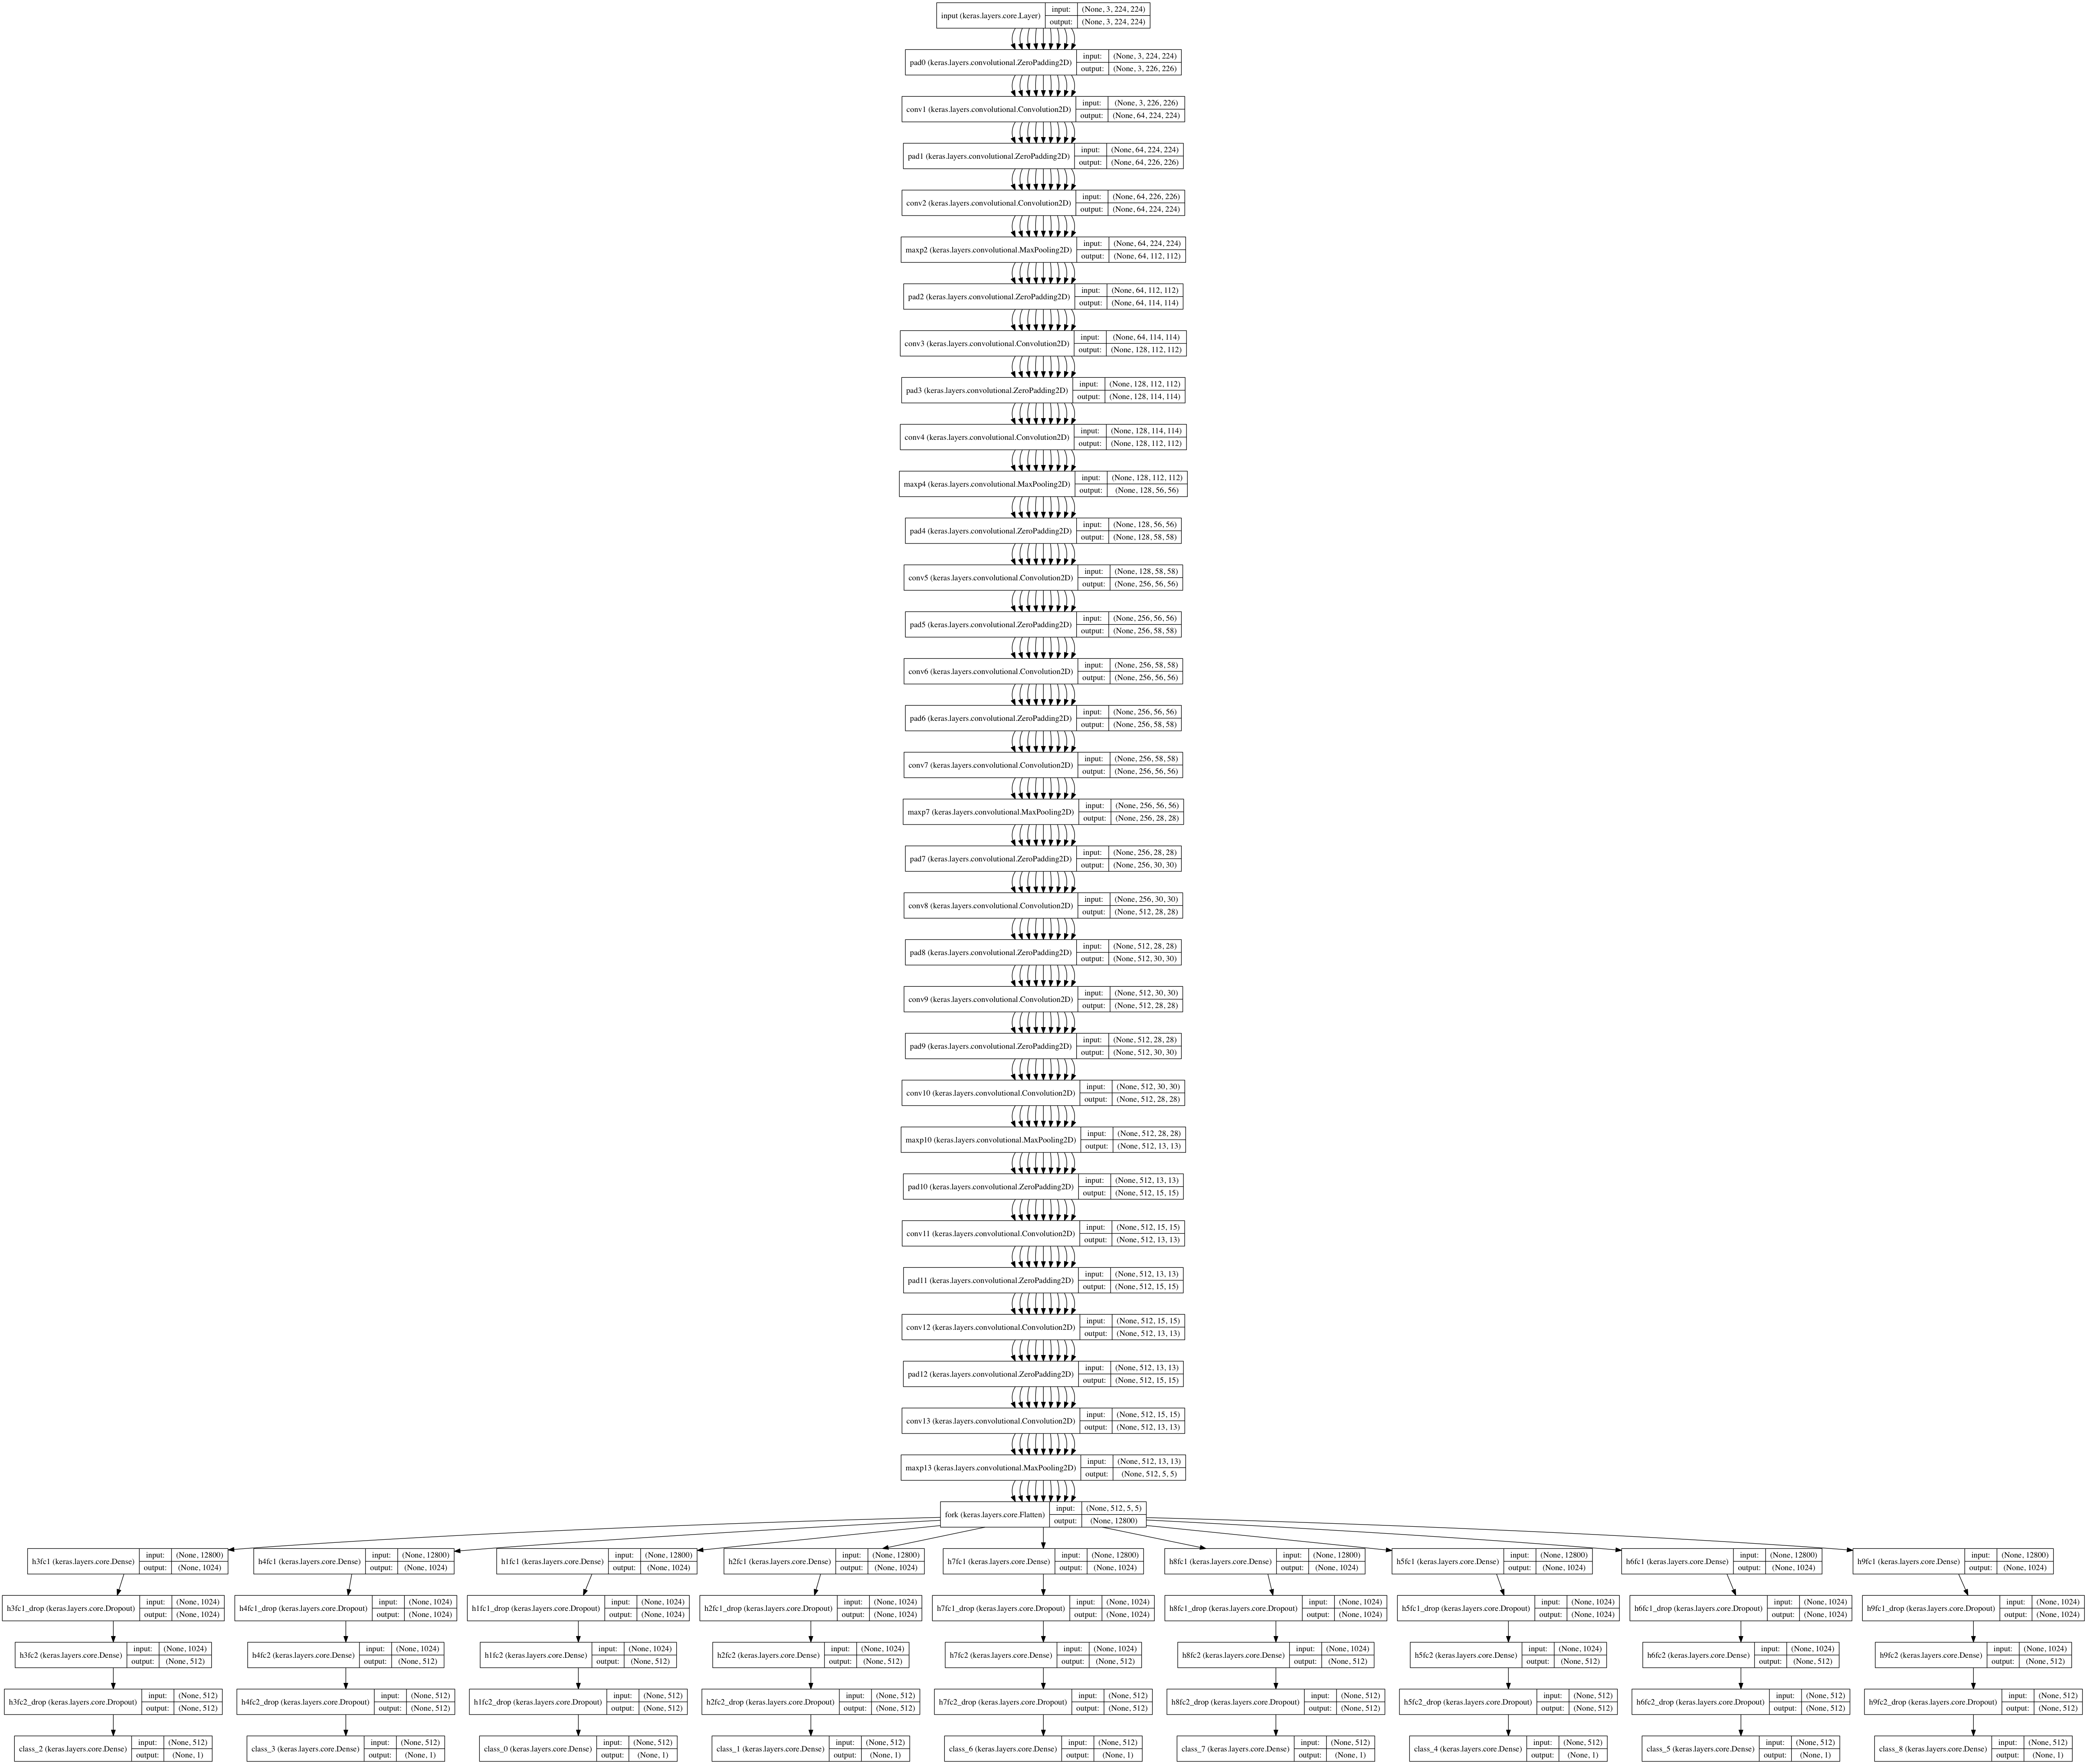

In [22]:
# Display yelp model
plot(yelp_model, to_file='graph.png', show_shape=True)
IPython.display.Image('./graph.png')
# SVG(to_graph(yelp_model, show_shape=True).create(prog='dot', format='svg'))

## Optimization

In [23]:
# Callbacks

tr_losses = []
class LossHistory(callbacks.Callback):
    
    def on_batch_end(self, batch, logs={}):
        tr_losses.append(logs.get('loss'))
       
history_cb = LossHistory()
early_stopping_cb = callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')
checkpointer_cb = callbacks.ModelCheckpoint(filepath="/tmp/weights.hdf5", verbose=1, save_best_only=True)

In [24]:
# Compile model
loss_dict = {}
for i in range(len(yelp_data_provider.restaurant_attributes)):
    loss_dict['class_'+str(i)] = 'binary_crossentropy'

# sgd = SGD(lr=0.0005, decay=0.0, momentum=0.9, nesterov=True)
adam = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
yelp_model.compile(optimizer=adam, loss=loss_dict)

In [25]:
# Reserve first batch for evaluation
X_valid, y_valid = yelp_data_provider.sample_training_minibatch(
                            size = 1024, percent_validation=0, replace = False, shuffle_before_each_epoch = True)

In [26]:
sample_size = 512

while yelp_data_provider.num_train_epoch != 3: # 3 full passes on training set
    
    # Random sample in minibatches to fit into RAM
    X_train, y_train = yelp_data_provider.sample_training_minibatch(
                            size = sample_size, percent_validation=0, replace = False, shuffle_before_each_epoch = True)

    print('Sampled {} training datapoints'.format(yelp_data_provider.num_train_sampled))
    
    # Prepare training info 
    keras_training_input = { 'input': X_train }
    for i in range(len(yelp_data_provider.restaurant_attributes)):
        keras_training_input['class_'+str(i)] = y_train[:,i].squeeze().astype('bool')

    yelp_model.fit( keras_training_input, batch_size=32, 
                        verbose=1, nb_epoch=1, validation_split=0.25, 
                        shuffle = False, 
                        callbacks=[history_cb, checkpointer_cb] ) # show_accuracy = True

In [27]:
# Test performance
predictions = yelp_model.predict({'input': X_valid}, batch_size=32)

In [28]:
for i in range(len(yelp_data_provider.restaurant_attributes)):
    class_prediction = predictions['class_'+str(i)].squeeze()
    class_prediction[class_prediction < 0.5] = 0
    class_prediction[class_prediction >= 0.5] = 1
    class_accuracy = np.mean( np.mean(y_valid[:,i] == class_prediction) )
    print('Class {} Accuracy {}'.format(i, class_accuracy))

In [29]:
yelp_model.save_weights("./yelp_restaurant_classifier_weights.h5")

## Test data

In [30]:
test_results_frame = pd.DataFrame(columns=("business_id", "labels"))
count = 0
for (biz_id, X_test) in yelp_data_provider.sample_test_biz_images():
    print "Infering for biz_id = ", biz_id
    predictions = yelp_model.predict({'input': X_test}, batch_size=32) # {class_name: num_samples x 1}
    predictions_mat = np.array(predictions.values()).squeeze() # num_classes x num_samples
    predictions_mat[predictions_mat < 0.5] = 0
    predictions_mat[predictions_mat >= 0.5] = 1
    biz_pred_str = " ".join([str(i) for i in range(9) if np.sum(predictions_mat[:,i])])
    test_results_frame.loc[count] = biz_id, biz_pred_str
    test_results_frame.to_csv("./submission.csv", index=None)
    count += 1
    if count == 10:
        print('biz_id procezsed = {}/{}'.format(count, len(yelp_data_provider.test_biz_to_ps)))

In [31]:
# save results
test_results_frame.to_csv("./submission.csv", index=None)

## GPU Test

In [32]:
#GPU test
from theano import function, config, shared, tensor, sandbox
import numpy
import time

vlen = 10 * 30 * 768  # 10 x #cores x # threads per core
iters = 1000

rng = numpy.random.RandomState(22)
x = shared(numpy.asarray(rng.rand(vlen), config.floatX))
f = function([], tensor.exp(x))
print(f.maker.fgraph.toposort())
t0 = time.time()
for i in range(iters):
    r = f()
t1 = time.time()
print("Looping %d times took %f seconds" % (iters, t1 - t0))
print("Result is %s" % (r,))
if numpy.any([isinstance(x.op, tensor.Elemwise) and
              ('Gpu' not in type(x.op).__name__)
              for x in f.maker.fgraph.toposort()]):
    print('Used the cpu')
else:
    print('Used the gpu')


In [33]:
# Check GPU Memory 
import theano.sandbox.cuda.basic_ops as sbcuda
import theano.tensor as T
T.config.floatX = 'float32'
GPUFreeMemoryInBytes = sbcuda.cuda_ndarray.cuda_ndarray.mem_info()[0]
freeGPUMemInGBs = GPUFreeMemoryInBytes/1024./1024/1024
print "Your GPU has %s GBs of free memory" % str(freeGPUMemInGBs)

In [ ]:
# Display vgg16 model
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
vgg16_model.compile(optimizer=sgd, loss='categorical_crossentropy')
SVG(to_graph(vgg16_model, show_shape=True).create(prog='dot', format='svg'))